In [1]:
import data

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-12-15 15:42:30.297508: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-15 15:42:30.324831: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 15:42:30.324860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 15:42:30.325548: E external/local

In [2]:
data = data.get_course_data()

100%|███████████████████████████████████████████| 12/12 [00:14<00:00,  1.24s/it]


In [3]:
# !pip install -U segmentation-models-pytorch albumentations --user
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.models.segmentation
from torchvision.transforms import ToTensor, ToPILImage
from torch.utils.data import Dataset, DataLoader
import cv2


import course_layer

import matplotlib.pyplot as plt
%matplotlib inline

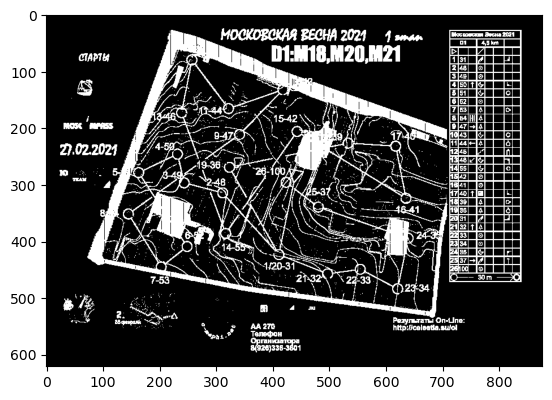

In [4]:
plt.imshow(data.draft.X[0], cmap='gray')


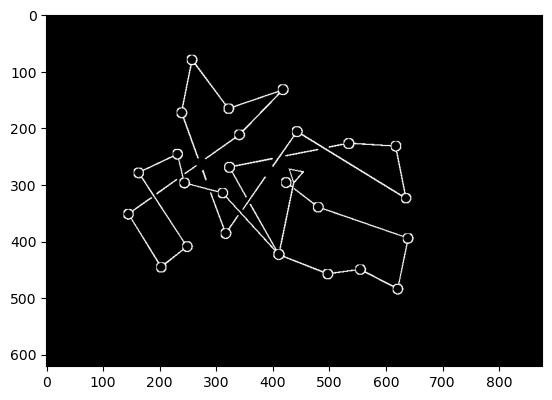

In [5]:
plt.imshow(data.draft.y[0], cmap='gray')

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
def downsample_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    f = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

In [8]:
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    return x

In [9]:
# https://stackoverflow.com/a/49290815
def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)

In [10]:
inputs = layers.Input(shape=(128,128,1))
f1, p1 = downsample_block(inputs, 16)
f2, p2 = downsample_block(p1, 32)
x = layers.Conv2D(64, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(p2)
x = layers.Dropout(0.3)(x)
u2 = upsample_block(x, f2, 32)
u1 = upsample_block(u2, f1, 16)
outputs = layers.Conv2D(1, 3, padding = "same", activation = "sigmoid", kernel_initializer = "he_normal")(u1)
unet_model = tf.keras.Model(inputs, outputs, name="U-Net")


2023-12-15 15:49:44.212848: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [11]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=["accuracy", jaccard_distance])

In [12]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         160       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [13]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, draft_data, sz, batch_size=16, dim=(128,128), n_channels=3,
                 shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.draft = draft_data
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.len = sz
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(self.len / self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.len)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            elem = self.draft[ID]
            # Store sample
            X[i,] = elem[0]

            # Store class
            y[i] = elem[1]

        return X, y

In [14]:
train = DataGenerator(data, 5000, n_channels=1)
val = DataGenerator(data, 64, n_channels=1)
# del data

In [15]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.TensorBoard()
]

In [16]:
model_history = unet_model.fit(train,
                               verbose=2,
                               epochs=10,
                               validation_data=val)

Epoch 1/10
312/312 - 55s - loss: 0.0585 - accuracy: 0.9802 - jaccard_distance: 59.8132 - val_loss: 0.0368 - val_accuracy: 0.9875 - val_jaccard_distance: 42.2216 - 55s/epoch - 178ms/step
Epoch 2/10
312/312 - 54s - loss: 0.0305 - accuracy: 0.9889 - jaccard_distance: 40.3925 - val_loss: 0.0241 - val_accuracy: 0.9910 - val_jaccard_distance: 35.3291 - 54s/epoch - 174ms/step
Epoch 3/10
312/312 - 53s - loss: 0.0268 - accuracy: 0.9903 - jaccard_distance: 35.4586 - val_loss: 0.0251 - val_accuracy: 0.9908 - val_jaccard_distance: 32.8680 - 53s/epoch - 171ms/step
Epoch 4/10
312/312 - 55s - loss: 0.0243 - accuracy: 0.9912 - jaccard_distance: 32.0201 - val_loss: 0.0223 - val_accuracy: 0.9917 - val_jaccard_distance: 29.9157 - 55s/epoch - 175ms/step
Epoch 5/10
312/312 - 51s - loss: 0.0226 - accuracy: 0.9917 - jaccard_distance: 29.6977 - val_loss: 0.0188 - val_accuracy: 0.9929 - val_jaccard_distance: 28.5103 - 51s/epoch - 162ms/step
Epoch 6/10
312/312 - 52s - loss: 0.0219 - accuracy: 0.9918 - jaccard_d

In [17]:
fig = plt.figure(figsize=(100, 100))
for i in range(5):
    X, y = val[0]#     X = X.permute(1, 2, 0).numpy()
    X = X[i]
    y = y[i]
    print(X.shape)
    print(y.shape)
    pred = unet_model.predict(np.array([X]))
    fig.add_subplot(5, 3, 3 * i + 1)
    plt.imshow(X)
    fig.add_subplot(5, 3, 3 * i + 2)
    plt.imshow(y * 255, cmap='gray')
    fig.add_subplot(5, 3, 3 * i + 3)
    plt.imshow(pred[0], cmap='gray')
plt.show()

(128, 128, 1)
(128, 128)
1/1 [==============================] - 0s 141ms/step
(128, 128, 1)
(128, 128)
1/1 [==============================] - 0s 22ms/step
(128, 128, 1)
(128, 128)
1/1 [==============================] - 0s 21ms/step
(128, 128, 1)
(128, 128)
1/1 [==============================] - 0s 22ms/step
(128, 128, 1)
(128, 128)
1/1 [==============================] - 0s 19ms/step


In [18]:
unet_model.save_weights('./checkpoints/unet_course_4')

In [19]:
unet_model.load_weights('checkpoints/unet_course_4')

In [36]:
img = cv2.imread('data/карта 15.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pred = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.float64)
inp = course_layer.course_color_mask(img)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1,1))
inp = cv2.dilate(inp, kernel)
for i in range(0, img.shape[0], 128):
    for j in range(0, img.shape[1], 128):
        if i + 128 > img.shape[0]:
            i = img.shape[0] - 128
        if j + 128 > img.shape[1]:
            j = img.shape[1] - 128
        pred[i:i+128,j:j+128] = unet_model.predict(inp[i:i+128,j:j+128].reshape(-1, 128, 128, 1) / 255)[0]

1/1 [==============================] - 0s 15ms/step


In [37]:
_, res = cv2.threshold(pred, 0.1, 1.0, cv2.THRESH_BINARY)
res = np.uint8(res * 255)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
# res = cv2.erode(res, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
res = cv2.dilate(res, kernel)
# res = cv2.medianBlur(res, 5)


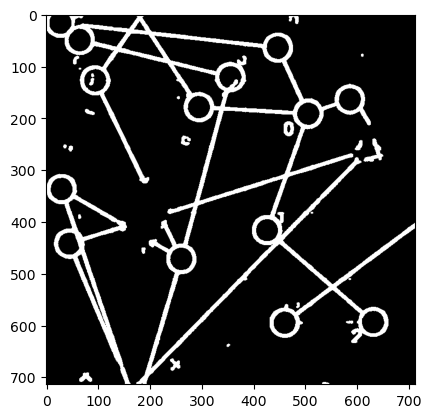

In [38]:
plt.imshow(res, cmap='gray')

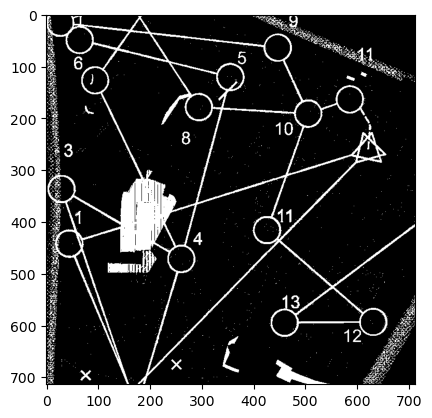

In [39]:
plt.imshow(inp, cmap='gray')

In [40]:
model_pred = course_layer.detect_course_model(img)

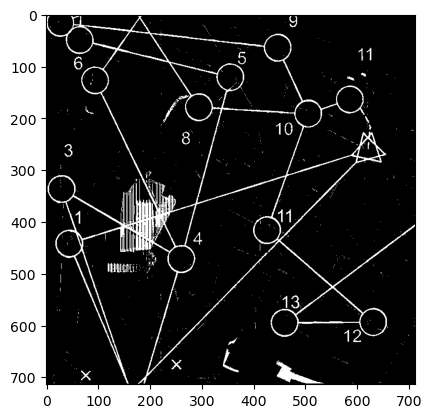

In [41]:
plt.imshow(model_pred, cmap='gray')